In [1]:
from IPython.display import Image

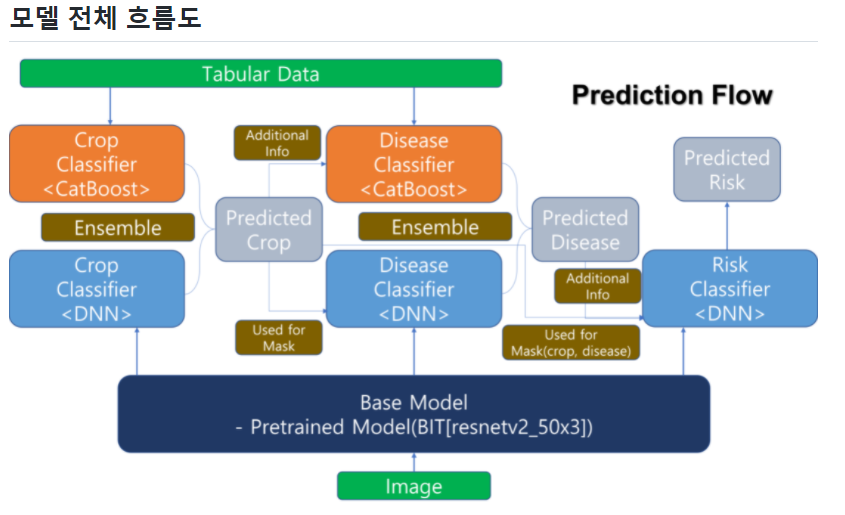

In [2]:
Image("../eruron/week3.png")

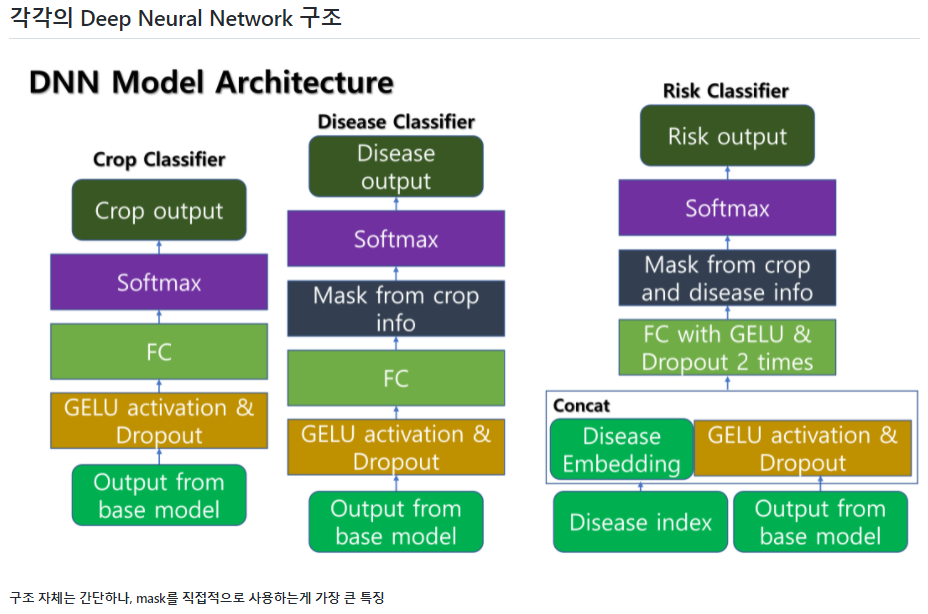

In [3]:
'''
[코드 설명]
meta_data.py : 기본 정보가 적혀 있음. 마스크 처리를 위한 것이 가장 핵심
data_preprocessing.py : 데이터 전처리를 위함. Train과 Test 방식을 분리하였음. K-fold 방식을 구현하긴 하였으나 사용하지 않기에 주석처리함. 필요시 사용 가능.
loss.py : Focal Loss 구현
model.py : 실제 사용한 모델.
train_cat.py : catboost를 훈련하기 위한 코드. grid search를 약간만 변형하면 진행할 수 있으며, 그 결과들과 feature importance 확인을 위한 부분은 주석처리되어 있음.
train_torch.py : Deep Neural Network 모델을 훈련하기 위한 코드. Batch size의 default는 44로 약 48GB의 GPU 메모리가 필요. 다만, 훈련 속도 감소를 감수한다면 amp 적용부분을 제거하면 되고, 20%가 넘는 batch 사이즈 증가가 가능.
predict.py : 실제 추론을 위한 코드. 위의 코드를 실행할때, default값은 전혀 손대지 않았다면 별 문제 없이 진행. 체크포인트 저장 위치 등을 바꾸었다면 그 경로를 입력해줘야 함.
'''

'''
[예측과제 & 모델 설명]
작물 이미지를 인풋으로 받아  label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열({crop}_{disease}_{risk}) 을 예측하는 문제
세가지 항목을 모두 맞춰야 정답인 것으로 단일 라벨 취급
-> 코드 저자는 이를 (crop)-(disease)-(risk)순의 조건부 확률로 생각.
-> 한 레벨의 라벨이 정해지면 그 양상에 따라 다음 레벨의 양상이 결정됨
    : crop에 따라 disease양상이 결정되며 crop과 disease에 따라 결과의 risk정도가 달라짐. 
-> 모델에 대한 저자의 설명:
    이렇게 과제를 바꿀 경우, 각각의 예측 성능을 최대화 하고, (crop)-(disease)-(risk) 순에 따라 예측된 결과를 추가적인 정보원으로 사용하면 예측 정확도가 더욱 높아질 수 있을 것으로 가정할 수 있음
    특히, 이미지 분류의 관점에서 최종적으로 필요한 feature는 다를 수 있으나, 공통 분모가 매우 많을 것으로 가정할 수 있음. 이는 과제가 본질적으로 동일한 대상에서 나타날 수 있는 상태 조건들의 조건부 확률에 기반하기 때문.
    따라서 base model과 이로부터 crop, disease, risk를 예측하는 Deep Neural Network 구조를 고안해 냄. 이는 속도 측면에서 또한 여러 개의 독립적인 모델보다 효율성이 높음
    동시에 Catboost에서도 이전에 예측한 조건(예시: disease 예측에는 crop에 대한 정보를 투입하는 것)을 투입하는 구조를 고안함.
-> Big Transfer를 단일 base model로 하여 그 base model에 이미지를 넣어서 나온 결과를 crop, disease, risk 각각의 classifier에 input으로 넣어 최종 예측을 수행.
    : 같은 모델로 feature extract 한뒤 세개의 classifier각각 사용
    Deep Neural Network의 경우, 단순 합산 loss 값을 사용하면, 예측해야하는 3가지 task 중, 중요도에 따른 모델의 차별적인 훈련이 불가능 해짐. 이를 위해 몇가지 트릭을 사용.
'''
'''
[모델 인풋 관련]
-> ignore index 사용
crop의 종류에 따라, 그리고 disease여부에 따라 이후 확률은 조건부 확률(e.g. 질병이 없으면 risk예측 필요 x) 이를 표지하기 위해 ignore index활용.
->Mask의 사용
: 마찬가지로 조건부 확률 적용을 위해 선행 확률로 인해 얻어지는 정보로 이후 확률을 구하는 범위를 마스크 하기 위해 사용.게 됨. 예를 들어 작물 중, 토마토의 경우, 질병 분류가 정상과 흰가루병밖에 없으며, 질병 심각도 또한 정상과 흰가루병에서의 중기 밖에 존재하지 않음. 따라서 이전에 예측에서 얻어진 정보로 이 부분에만 예측을 제한시키도록 마스크를 이용해 결과를 제약할 수 있음.
->
'''

Image("../eruron/week3_2.png")

In [ ]:
# model.py의 내용

import timm
import torch.nn as nn
import torch
from meta_data import disease_encoding

# timm에서 pretrained 'resnetv2_50x3_bitm_in21k' 모델을 가져와서 베이스라인으로 사용
class BaseModel(nn.Module):
    def __init__(self, num_classes=1000, drop_p=0., pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('resnetv2_50x3_bitm_in21k', pretrained=pretrained, num_classes=num_classes, drop_rate=drop_p,)
            
    @torch.cuda.amp.autocast()
    def forward(self, img):
        return self.model(img)


# 작물코드(crop)에 대한 classifier
class CropHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=6, drop_p=0.1):
        super().__init__()
        self.classifier = nn.Linear(num_base_features, num_classes)
        self.act = nn.GELU() # Gaussian Error Linear Units라는 activation 함수임.
        self.drop = nn.Dropout(drop_p) 
    
    @torch.cuda.amp.autocast() # mixed bit precision에 대한 패키지 -> gpu 연산/메모리 절약 
    def forward(self, x):
        return self.classifier(self.act(self.drop(x)))

# 모델 받아서 classifier 적용
class CropClassifier(nn.Module):
    def __init__(self, num_base_features=1000,num_classes=6, drop_p=0.1):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = CropHeadClassifier(num_base_features=num_base_features, num_classes=num_classes, drop_p=drop_p)
        
    def forward(self, x, not_use=None):
        return self.classifier(self.base_model(x))
    
# 작물상태/질병코드(disease)에 대한 classifier
class DiseaseHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=13, drop_p=0.1):
        super().__init__()
        self.classifier = nn.Linear(num_base_features, num_classes)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop_p)
        
    @torch.cuda.amp.autocast()
    def forward(self, x, mask):
        x = self.classifier(self.act(self.drop(x)))
        x.masked_fill_(mask, -10000.)
        return x

# 역시 모델 받아서 classifier 적용
class DiseaseClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=13, drop_p=0.1):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = DiseaseHeadClassifier(num_base_features=num_base_features, num_classes=num_classes, drop_p=drop_p)
        
    def forward(self, x, mask):
        return self.classifier(self.base_model(x), mask)
     
# 질병 피해 정도(risk)에 대한 classifier
class RiskHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, hidden_feature=200, num_classes=4, drop_p=0.1, embedding_dim=10):
        super().__init__()
        self.linear = nn.Linear(num_base_features + embedding_dim, hidden_feature)
        self.classifier = nn.Linear(hidden_feature, num_classes)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop_p)
        self.embedding = nn.Embedding(num_embeddings=len(disease_encoding), embedding_dim=embedding_dim)
    
    @torch.cuda.amp.autocast()
    def forward(self, x, disease_code, mask):
        x = self.act(self.drop(x))
        y = self.drop(self.embedding(disease_code))
        concat = torch.cat([x, y], dim=1)
        out = self.act(self.drop(self.linear(concat)))
        out = self.classifier(out)
        out.masked_fill_(mask, -10000.)
        return out

 # 역시 모델 받아서 classifier 적용       
class RiskClassifier(nn.Module):
    def __init__(self, num_base_features=1000, hidden_feature=200, num_classes=4, drop_p=0.1, embedding_dim=100):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = RiskHeadClassifier(num_base_features=num_base_features, hidden_feature=hidden_feature, num_classes=num_classes, drop_p=drop_p, embedding_dim=embedding_dim)
        
    def forward(self, x, disease_code, mask):
        return self.classifier(self.base_model(x), disease_code, mask)

In [ ]:
# loss.py의 내용
'''
-> Focal Loss의 사용
: 단순히 세가지 classifier 예측값으로 부터 구해진 cost를 더하는 loss func은 예리하지 못함. 
: 학습이 더 필요한 classifier의 loss 가중치를 더 크게하자는 아이디어
: 이 loss 값은 기본적으로 예측을 잘하는 대상에 대한 loss 값을 줄임으로써 다른 빈도수가 낮고 아직 모델이 잘 예측하지 못하는 범주에 대한 loss 값을 상대적으로 크게하는 방식.
실제로 각각의 classifier loss에 기여하는 데이터의 비율이 다른 가운데, 잘 예측하는 것의 loss 값에 대한 영향력을 축소시킬 필요가 있음. 
극단적인 예로는 Risk 3단계의 경우 전체 데이터의 1% 정도에 불과함. 
이를 사용함으로써 얻는 효과는, 모델이 아직 학습이 덜 된 범주의 데이터에 초점을 맞추고, 실제 데이터 비율이 적더라도 이에 더욱 초점을 맞춤으로써 효과적인 학습이 가능해 질 수 있음.
예를 들자면, 결과적으로 crop 예측을 매우 잘할 경우 crop classifier의 성능 개선의 중요도는 떨어지고 다른 classifier의 성능 개선이 필요하게 되는데, 이를 자동으로 조절해주는 역할을 하게 됨.
'''

import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='none')

    @torch.cuda.amp.autocast()
    def forward(self, inputs, targets, mixup=None):
        loss = self.loss_fn(inputs, targets)
        pt = torch.exp(-loss)
        F_loss = self.alpha * (1-pt)**self.gamma * loss  # 논문에 나온 식 구현 
        
        if mixup is not None:
            F_loss = F_loss * mixup
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        elif self.reduction == 'none':
            return F_loss

In [ ]:
# train_cat.py내용

import os
import argparse
import glob
import pandas as pd
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from meta_data import disease_encoding

parser = argparse.ArgumentParser(description='Select Train Mode')
parser.add_argument('--target', type=str, required=True, choices=['crop', 'disease', 'risk'], help='Select target label.')
parser.add_argument('--save-folder', type=str, default=None, help='Save folder for Model. Recommand Not To Use.')
parser.add_argument('--dataset-folder', type=str, default='stratified_dataset', help='Dataset folder made by data preprocessing')
parser.add_argument('--early-stop', type=int, default=1000)
args = parser.parse_args()

BASE_SAVE_FOLDER = 'model_checkpoint/boosting'
EARLY_STOP_COUNT = args.early_stop

target_label = args.target
save_folder = args.save_folder
dataset_folder = args.dataset_folder
if save_folder:
    os.makedirs(save_folder, exist_ok=True)
else:
    if target_label in ('crop', 'disease', 'risk'):
        save_folder = os.path.join(BASE_SAVE_FOLDER, target_label)
        os.makedirs(save_folder, exist_ok=True)
    else:
        print("Check the label name")
        exit()

if target_label == 'crop':
    total_labels = [i for i in range(6)]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist']
    drop_labels = ['crop', 'disease', 'risk']
elif target_label == 'disease':
    total_labels = [i for i in range(len(disease_encoding))]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist', 'crop']
    drop_labels = ['disease', 'risk']
elif target_label == 'risk':
    total_labels = [i for i in range(4)]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist', 'crop', 'disease']
    drop_labels = ['risk']
    
train_csv_files = sorted(glob.glob(dataset_folder + '/*train.csv'))
test_csv_files = sorted(glob.glob(dataset_folder + '/*test.csv'))

for k_fold, (train_csv, test_csv) in enumerate(zip(train_csv_files, test_csv_files)):
    train_df = pd.read_csv(train_csv)
    train_df = train_df.drop(columns=ignored_features)
    train_x, train_y = train_df.drop(columns=drop_labels), train_df[target_label]
    
    test_df = pd.read_csv(test_csv)
    test_df = test_df.drop(columns=ignored_features)
    test_x, test_y = test_df.drop(columns=drop_labels), test_df[target_label]
    
    if target_label == 'crop':
        border_count = [7]
        random_strength = [1]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]

    elif target_label == 'disease':
        border_count = [64]
        random_strength = [2]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]

    elif target_label == 'risk':
        border_count = [64]
        random_strength = [2]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]
        
    grids = [(leaf, learn, streng, border) for leaf in leaf_estimation_iterations for learn in learning_rate for streng in random_strength for border in border_count]
    
    max_acc = -float('inf')
    max_f1 = -float('inf')
    
    for leaf, learn, streng, border in tqdm(grids):
        model = CatBoostClassifier(
            iterations = 1000000,
            task_type = 'GPU',
            devices='0',
            thread_count = 16,
            learning_rate = learn,
            border_count=border,
            random_strength=streng,
            leaf_estimation_iterations=leaf,
            auto_class_weights='Balanced',
            max_depth=8,
            eval_metric='TotalF1',
            use_best_model=True,
            cat_features=cat_features,
            verbose=True,
        )
        model.fit(
            train_x, train_y,
            eval_set = [(test_x, test_y)],
            early_stopping_rounds=EARLY_STOP_COUNT
        )
        
        preds = model.predict(test_x)
        res = model.score(test_x, test_y)
        report = classification_report(test_y, preds)
        f1_score_result = f1_score(test_y, preds, average='macro', labels=total_labels)
        print(report)
        preds_train = model.predict(train_x)
        report = classification_report(train_y, preds_train)
        print( '-' *100)
        print(report)
        print(f'{target_label}--F1 Score:', f1_score_result, '\tAcc:', res, '\tBest F1 Score:', max(max_f1, f1_score_result), '\tBest Acc:', max(max_acc, res))

In [ ]:
# train.torch의 내용

import argparse
import os
import glob
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from model import BaseModel, CropHeadClassifier, DiseaseHeadClassifier, RiskHeadClassifier
from utils import TrainValDataset, total_acc_cal
from meta_data import disease_encoding
from loss import FocalLoss

# parser 내용 생략(코드 안 돌림)

save_folder = args.save_folder
dataset_folder = args.dataset_folder
if save_folder:
    os.makedirs(save_folder, exist_ok=True)
else:
    save_folder = os.path.join(BASE_SAVE_FOLDER, 'trained')
    os.makedirs(save_folder, exist_ok=True)

total_crop_labels = [i for i in range(6)]
total_disease_labels = [i for i in range(len(disease_encoding))]
total_risk_labels = [i for i in range(4)]

train_csv_files = sorted(glob.glob(dataset_folder + '/*train.csv'))
test_csv_files = sorted(glob.glob(dataset_folder + '/*test.csv'))

crop_cat = CatBoostClassifier()
disease_cat = CatBoostClassifier()
for cat_file_path, cat_model in zip(sorted(glob.glob(args.checkpoint_cat+'/*/*_0.pkl')), [crop_cat, disease_cat]):
    cat_model.load_model(cat_file_path)

    
# ford / batch 로 학습 loop
for k_fold, (train_csv, test_csv) in enumerate(zip(train_csv_files, test_csv_files)):
    print("Train csv and Test csv:", train_csv, '\t', test_csv)
    train_dataset = TrainValDataset(train_csv, train=True, target_label='total')
    test_dataset = TrainValDataset(test_csv, train=False, target_label='total')
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=BATCH_SIZE*2, drop_last=True, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=BATCH_SIZE*2, drop_last=False, pin_memory=True)
    
    base_model = BaseModel(drop_p=BASE_DROP_RATE)
    base_model = torch.nn.DataParallel(base_model).to(DEVICE)
    crop_model = CropHeadClassifier(drop_p=CROP_DROP_RATE)
    crop_model = torch.nn.DataParallel(crop_model).to(DEVICE)
    disease_model = DiseaseHeadClassifier(drop_p=DISEASE_DROP_RATE)
    disease_model = torch.nn.DataParallel(disease_model).to(DEVICE)
    risk_model = RiskHeadClassifier(drop_p=RISK_DROP_RATE)
    risk_model = torch.nn.DataParallel(risk_model).to(DEVICE)
    
    scaler = torch.cuda.amp.GradScaler()
    
    loss_fn = FocalLoss()
    loss_fn_disease_risk = FocalLoss(ignore_index=0) # loss에 idx적용
    optimizer = torch.optim.AdamW([
        {'params': base_model.parameters()}, 
        {'params': crop_model.parameters()}, 
        {'params': disease_model.parameters()}, 
        {'params': risk_model.parameters()}], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    writer = SummaryWriter(os.path.join(save_folder, 'log')) # 텐서보드에 로그 정보를 제공하는 객체 생성 함수
    step = 0
    stop_count = 0
    current_epoch = 0
    max_f1_average = -float('inf')
    max_f1_total = -float('inf')
    max_f1_ensemble = -float('inf')
    max_f1_total_risk_care = -float('inf')
    max_f1_ensemble_risk_care = -float('inf')
    max_average_acc = -float('inf')
    max_all_acc = -float('inf')
    answer_crop = test_dataset.df['crop'].to_list()
    answer_disease = test_dataset.df['disease'].to_list()
    answer_risk = test_dataset.df['risk'].to_list()
    answer_total = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(answer_crop, answer_disease, answer_risk)]

    # 학습진행
    while True:
        stop_count += 1
        current_epoch += 1
        base_model.train()
        crop_model.train()
        disease_model.train()
        risk_model.train()
        
        for data in train_dataloader:
            img, crop, disease, risk, disease_mask, risk_mask = data
            
            with torch.cuda.amp.autocast():
                img = img.to(DEVICE)
                crop = crop.to(DEVICE)
                disease = disease.to(DEVICE)
                risk = risk.to(DEVICE)
                disease_mask = disease_mask.to(DEVICE)
                risk_mask = risk_mask.to(DEVICE)
                img_processed = base_model(img)
                crop_logits = crop_model(img_processed)
                disease_logits = disease_model(img_processed, disease_mask)
                risk_logits = risk_model(img_processed, disease, risk_mask)
                loss = loss_fn(crop_logits, crop) + loss_fn_disease_risk(disease_logits, disease) + loss_fn_disease_risk(risk_logits, risk) #1.5, 15
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            writer.add_scalar(f'Loss/train_step_{k_fold}', loss, step)
            step += 1
        
        base_model.eval()
        crop_model.eval()
        disease_model.eval()
        risk_model.eval()
        total_loss = 0
        preds_crop = []
        preds_disease = []
        preds_risk = []
        preds_crop_ensem = []
        preds_disease_ensem = []
        preds_risk_ensem = []
        with torch.no_grad():
            for idx, data in enumerate(test_dataloader):
                img, crop, disease, risk, disease_mask, risk_mask = data
                img = img.to(DEVICE)
                crop = crop.to(DEVICE)
                disease = disease.to(DEVICE)
                risk = risk.to(DEVICE)
                disease_mask_np = disease_mask.numpy()
                disease_mask = disease_mask.to(DEVICE)
                risk_mask = risk_mask.to(DEVICE)
                with torch.cuda.amp.autocast(): # mixed precision은 torch.nograd처럼 for문으로 적용한다
                    img_processed = base_model(img)
                    crop_logits = crop_model(img_processed)
                    disease_logits = disease_model(img_processed, disease_mask)
                    risk_logits = risk_model(img_processed, disease, risk_mask)
                    
                    loss = loss_fn(crop_logits, crop) + loss_fn_disease_risk(disease_logits, disease) + loss_fn_disease_risk(risk_logits, risk)
                
                    target_df = test_dataset.df.iloc[BATCH_SIZE*idx: BATCH_SIZE*(idx + 1), :].drop(columns=['img_path', 'coordinate', 'crop', 'disease', 'risk'])
                    crop_boost_pro = crop_cat.predict_proba(target_df)
                    crop_DL_pro = crop_logits.softmax(dim=-1).detach().cpu().numpy()
                    crop_idx_list = np.argmax(crop_DL_pro + crop_boost_pro, axis=-1).tolist()
                    preds_crop_ensem.extend(crop_idx_list)
                    
                    
                    disease_DL_pro = disease_logits.softmax(dim=-1).detach().cpu().numpy()
                    target_df = test_dataset.df.iloc[BATCH_SIZE*idx: BATCH_SIZE*(idx + 1), :].drop(columns=['img_path', 'coordinate', 'disease', 'risk'])
                    disease_boost_pro = disease_cat.predict_proba(target_df)
                    disease_boost_pro = np.ma.MaskedArray(data=disease_boost_pro, mask=disease_mask_np)
                    disease_idx_list = np.argmax(disease_DL_pro + disease_boost_pro.data, axis=-1).tolist()
                    preds_disease_ensem.extend(disease_idx_list)
                
                
                total_loss += loss * len(img)
                preds_crop.extend(np.argmax(crop_DL_pro, axis=-1))
                preds_disease.extend(np.argmax(disease_DL_pro, axis=-1))
                preds_risk.extend(torch.argmax(risk_logits, dim=-1).detach().cpu().tolist())
                
                
            preds_total = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(preds_crop, preds_disease, preds_risk)]
            preds_total_ensem = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(preds_crop_ensem, preds_disease_ensem, preds_risk)]
            f1_score_crop = f1_score(answer_crop, preds_crop, average='macro', labels=total_crop_labels)
            f1_score_crop_ensem = f1_score(answer_crop, preds_crop_ensem, average='macro', labels=total_crop_labels)
            f1_score_disease = f1_score(answer_disease, preds_disease, average='macro', labels=total_disease_labels)
            f1_score_disease_ensem = f1_score(answer_disease, preds_disease_ensem, average='macro', labels=total_disease_labels)
            f1_score_risk = f1_score(answer_risk, preds_risk, average='macro', labels=total_risk_labels)
            f1_score_total = f1_score(answer_total, preds_total, average='macro')
            f1_score_total_ensem = f1_score(answer_total, preds_total_ensem, average='macro')
            
            acc_score_crop = accuracy_score(answer_crop, preds_crop)
            acc_score_disease = accuracy_score(answer_disease, preds_disease)
            acc_score_risk = accuracy_score(answer_risk, preds_risk)
            #acc_score_total = accuracy_score(answer_total, preds_total)
            
            writer.add_scalar(f'Loss/test_epoch_{k_fold}', total_loss/len(test_dataset), current_epoch)
            writer.add_scalar(f'Acc/Crop_{k_fold}', acc_score_crop, current_epoch)
            writer.add_scalar(f'Acc/Disease_{k_fold}', acc_score_disease, current_epoch)
            writer.add_scalar(f'Acc/Risk_{k_fold}', acc_score_risk, current_epoch)
            #writer.add_scalar(f'Acc_total/test_epoch_{k_fold}', acc_score_total, current_epoch)
            writer.add_scalar(f'F1/Crop_{k_fold}', f1_score_crop, current_epoch)
            writer.add_scalar(f'F1/Disease_{k_fold}', f1_score_disease, current_epoch)
            writer.add_scalar(f'F1/Risk_{k_fold}', f1_score_risk, current_epoch)
            writer.add_scalar(f'F1/Total_{k_fold}', f1_score_total, current_epoch)
            writer.add_scalar(f'F1/En_Crop_{k_fold}', f1_score_crop_ensem, current_epoch)
            writer.add_scalar(f'F1/En_Disease_{k_fold}', f1_score_disease_ensem, current_epoch)
            writer.add_scalar(f'F1/En_Risk_{k_fold}', f1_score_risk, current_epoch)
            writer.add_scalar(f'F1/En_Total_{k_fold}', f1_score_total_ensem, current_epoch)
            
            f1_average_score = (f1_score_crop + f1_score_disease + f1_score_risk) / 3
            acc_average_score = (acc_score_crop + acc_score_disease + acc_score_risk) / 3
            acc_all_score = total_acc_cal(preds_crop, answer_crop, preds_disease, answer_disease, preds_risk, answer_risk)        
            writer.add_scalar(f'F1/Average_{k_fold}', f1_average_score, current_epoch)
            writer.add_scalar(f'Acc/Average_{k_fold}', acc_average_score, current_epoch)
            writer.add_scalar(f'Acc/All_{k_fold}', acc_all_score, current_epoch)
    
         # 앙상블....????? 밑에 이해 잘 x
        if max_f1_total < f1_score_total:
            stop_count = 0
            max_f1_total = f1_score_total
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_total_{k_fold}.pt'))
        
        if max_f1_ensemble < f1_score_total_ensem:
            stop_count = 0
            max_f1_ensemble = f1_score_total_ensem
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_ensem_{k_fold}.pt'))
        
        if max_f1_total_risk_care < f1_score_total and f1_score_crop == 1 and f1_score_disease == 1:
            stop_count = 0
            max_f1_total_risk_care = f1_score_total
            print(f'DL only F1 Score: {max_f1_total_risk_care}')
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_total_risk_care_{k_fold}.pt'))
        
        if max_f1_ensemble_risk_care < f1_score_total_ensem and f1_score_crop_ensem == 1 and f1_score_disease_ensem == 1:
            stop_count = 0
            max_f1_ensemble_risk_care = f1_score_total_ensem
            print(f'Ensemble F1 Score: {max_f1_ensemble_risk_care}')
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_ensem_risk_care_{k_fold}.pt'))
        
        
        if stop_count == EARLY_STOP_COUNT:
            print(f'{k_fold}: Training Complete.')
            break